# An Analysis of the Ability of Multiple Supervised Learning Classification Models to Predict Late Airline Arrivals

<br>

Flight delay is a problem that can result in a rippling disruption in airline business processes.
To better understand how underlying factors affect the prevalence of flight delay, I am interested in predicting late airline arrivals.
There are many possible causes of flight delay.
The main causes of airline delays involve weather, air traffic, go-arounds, and mechanical problems.
In addition to aforementioned causes, there is arrival delay which is the delay caused by the same airplane arriving late to the previous airport.
This can result in systematic delay across an airline.
Extremely late airline delays may result in compensation to passengers, negatively affecting an airline's bottom line.
Being able to detect potentially late flights would improve the accuracy of demand prediction, which influences many management decisions. 
Using machine learning techniques allows for another perspective that can be used to model flight delay.


In this study, several different types of supervised learning classification models were used on the same labeled airline data to analyze their compared effectiveness when it comes to predicting late arrivals. 
In addition to this each model type was run three times using different methods to prepare the feature variables. 
This gave insight as to which types of models and feature engineering methods were best suited to predict late airline arrival based on the data.
The process used to undertake this study is as follows: 



Data Exploration and Analysis
* Viewing the Distribution of the Datapoints
* Checking the Correlatedness of the Classes

Preparing The Data For Modeling
* Dealing With Class Imbalance
* Principal Component Analysis

Modeling the Data 
* Naive Bayes
* K Nearest Neighbors
* Decision Trees
* Random Forest
* Logistic Regression (and Lasso and Ridge)
* Support Vector Classifier
* Gradient Boost

 



In [1]:
%%time

import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.mlab import PCA as mlabPCA
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn.utils import resample
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from datetime import datetime
from dateutil.parser import parse

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="sklearn"  
    )

# Set Plot Style
sns.set_style('white')

CPU times: user 1.47 s, sys: 413 ms, total: 1.88 s
Wall time: 1.41 s


In [2]:
%%time

## Import Files

df = pd.read_csv('2008.csv')

## Sample Original Data for Computational Efficiency

df = df.sample(n=1000000, random_state=10)

CPU times: user 18.7 s, sys: 6.14 s, total: 24.9 s
Wall time: 25.9 s


In [3]:
## View Data for Cleaning

#df.head(7)
#df.dtypes
#df.describe()
#df.isnull().sum(axis = 0)

In [4]:
%%time

## Dealing with Null Values

df = df.drop(['CancellationCode', 'CarrierDelay', 
              'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)
df = df.dropna()

CPU times: user 833 ms, sys: 211 ms, total: 1.04 s
Wall time: 1.05 s


In [5]:
%%time

## Turning Arrival and Departure Times into DateTime Format

df[['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',  'ArrTime', 'CRSArrTime'
   ]] = df[['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',  'ArrTime', 'CRSArrTime'
           ]].applymap(str)

def remove_tens_place(x):
    return x[:-2]

def add_new_zero(x):   
    if len(x) == 3:
        x = '0' + x
    return x

def alt_to_datetime(x):
    return pd.to_datetime(x, format='%Y%m%d%H%M', errors='coerce')

df.DepTime = df.DepTime.apply(remove_tens_place).apply(add_new_zero)
df.CRSDepTime = df.CRSDepTime.apply(add_new_zero)
df.ArrTime = df.ArrTime.apply(remove_tens_place).apply(add_new_zero)
df.CRSArrTime = df.CRSArrTime.apply(add_new_zero)

df.DepTime = df.Year + df.Month + df.DayofMonth + df.DepTime
df.CRSDepTime = df.Year + df.Month + df.DayofMonth + df.CRSDepTime
df.ArrTime = df.Year + df.Month + df.DayofMonth + df.ArrTime
df.CRSArrTime = df.Year + df.Month + df.DayofMonth + df.CRSArrTime

df.DepTime = df.DepTime.apply(alt_to_datetime)
df.CRSDepTime = df.CRSDepTime.apply(alt_to_datetime)
df.ArrTime = df.ArrTime.apply(alt_to_datetime)
df.CRSArrTime = df.CRSArrTime.apply(alt_to_datetime)

CPU times: user 11min 41s, sys: 8.14 s, total: 11min 49s
Wall time: 12min 1s


In [6]:
%%time

## Creating a Late Arrival Class to Serve as Outcome Variable

df['LateArr'] = (df.ArrTime - df.CRSArrTime).apply(lambda x: x.total_seconds())
df['LateArr'] = df.LateArr.where(df.LateArr >= 30*60, 0)
df['LateArr'] = df.LateArr.where(df.LateArr < 30*60, 1)


CPU times: user 10.6 s, sys: 222 ms, total: 10.8 s
Wall time: 10.9 s


In [7]:
%%time

## Handle New Null Values and Drop Unnecessary Columns

df = df.dropna()
df = df.drop(['Year', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum'], axis=1)

## Return Remaining Time Variables to String

df[['Month', 'DayofMonth', 'DayOfWeek']] = df[['Month', 'DayofMonth', 'DayOfWeek']].applymap(int)

## Reset Index

df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)

CPU times: user 3.78 s, sys: 1.14 s, total: 4.92 s
Wall time: 5.5 s


## Data Exploration and Analysis

Dataset used for this study includes information about each flight that may be consequential to the likelihood of late airline arrivals.
Such information includes: the time period of the flights, the airline, the location, associated flight diversions, and information about the length of time of individual parts of the flights.
The data being used in this study comes from the Bureau of Transportation Statistics and reflect all flights that data was collected for in the year 2008. 




In [8]:
%%time

df.head(7)

CPU times: user 350 µs, sys: 21 µs, total: 371 µs
Wall time: 363 µs


,Month,DayofMonth,DayOfWeek,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,LateArr
0,4,28,1,WN,N775SW,80.000,80.000,61.000,-1.000,-1.000,SJC,LAS,386,13.000,6.000,0,0,0.000
1,2,28,4,WN,N506SW,65.000,70.000,52.000,-5.000,0.000,CMH,MDW,284,4.000,9.000,0,0,0.000
2,8,26,2,OO,N756SK,102.000,89.000,74.000,6.000,-7.000,OKC,DEN,495,20.000,8.000,0,0,0.000
3,7,15,2,UA,N312UA,88.000,95.000,75.000,132.000,139.000,EUG,SFO,451,4.000,9.000,0,0,1.000
4,7,14,1,WN,N255WN,57.000,65.000,42.000,-9.000,-1.000,MDW,DTW,229,8.000,7.000,0,0,0.000
5,11,29,6,OO,N233SW,44.000,44.000,21.000,54.000,54.000,LAX,SBA,89,5.000,18.000,0,0,1.000
6,8,10,7,DL,N913DN,164.000,157.000,126.000,-3.000,-10.000,SLC,DFW,988,12.000,26.000,0,0,0.000


Above is the first several rows of the dataset after preliminary cleaning was done to remove null values and label the data.
The newly engineered outcome variable "LateArr" labels a flight as late (1) if it arrived over 30 minutes past its scheculed arrival time and not late (0) otherwise.

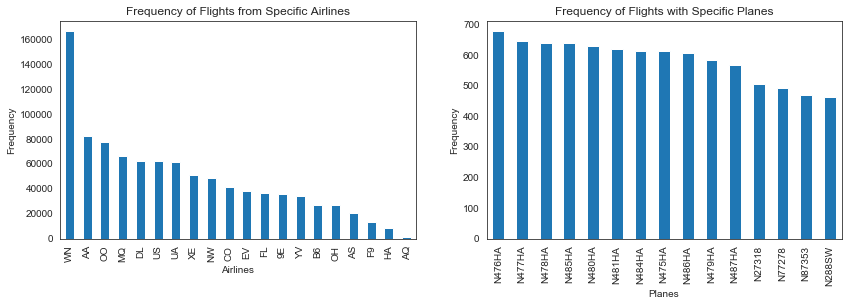

CPU times: user 1.47 s, sys: 234 ms, total: 1.7 s
Wall time: 972 ms


In [9]:
%%time

## Barplot of Specific Airlines

fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=.5)

plt.subplot(1, 2, 1)
ax = df.UniqueCarrier.value_counts().plot(kind='bar',
                                    
                                    title="Frequency of Flights from Specific Airlines")
ax.set_xlabel("Airlines")
ax.set_ylabel("Frequency")

## Barplot of Specific Planes

plt.subplot(1, 2, 2)
ax = df.TailNum.value_counts().head(15).plot(kind='bar',
                                    
                                    title="Frequency of Flights with Specific Planes")
ax.set_xlabel("Planes")
ax.set_ylabel("Frequency")

plt.show()

The graph on the left shows the number of flights that took place with each airline (per million flights).
There is a large range in the number of flights that took place with each airline.
Southwest Airlines (WN) had a significantly larger number of flights then the second most busy airline, American Airlines (AA).

The Graph on the right shows the 15 most used planes.
Of these 15, one of the least active airlines in terms of flights, Hawaiian Airlines (HA) accounted for 11.
This implies that this smaller airline has relies on fewer planes to conduct a proportionally larger amount of the flights.


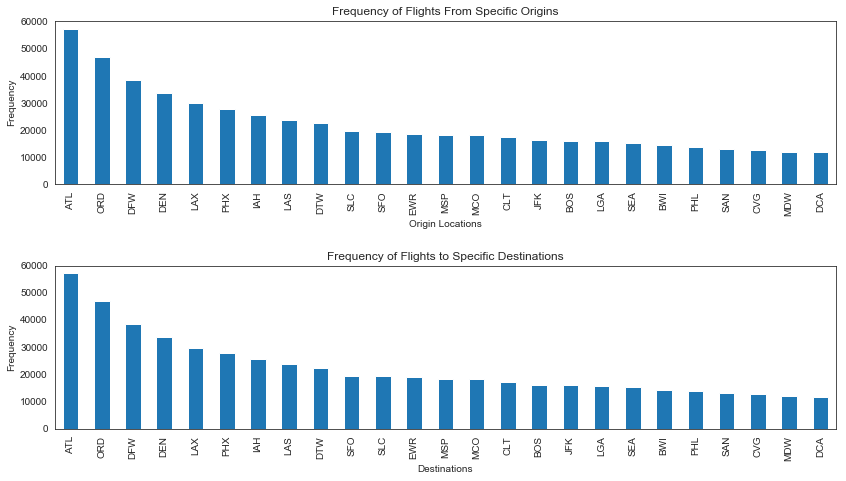

CPU times: user 1.43 s, sys: 164 ms, total: 1.59 s
Wall time: 937 ms


In [10]:
%%time

## Barplot of Specific Airlines

fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=.5)

plt.subplot(3, 1, 1)
ax = df.Origin.value_counts().head(25).plot(kind='bar',
                                    
                                    title="Frequency of Flights From Specific Origins")
ax.set_xlabel("Origin Locations")
ax.set_ylabel("Frequency")

## Barplot of Specific Planes

plt.subplot(3, 1, 2)
ax = df.Dest.value_counts().head(25).plot(kind='bar',
                                    
                                    title="Frequency of Flights to Specific Destinations")
ax.set_xlabel("Destinations")
ax.set_ylabel("Frequency")

plt.show()

The airports with the most air travel in the United States are Atlanta, Chicago and Dallas respectively. 
The lack of descrepancy between origin and destination locations show that there aren't any outside factors outside of flight affecting the locations of the planes.

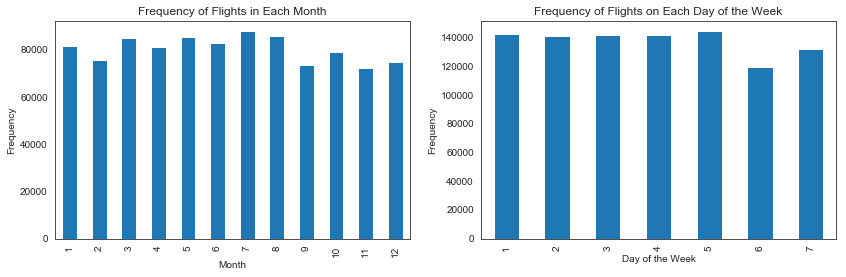

CPU times: user 754 ms, sys: 115 ms, total: 869 ms
Wall time: 410 ms


In [11]:
%%time

## Barplot of Specific Airlines

fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=.5)

plt.subplot(1, 2, 1)
ax = df.Month.value_counts().sort_index().head(25).plot(kind='bar',
                                    
                                    title="Frequency of Flights in Each Month")
ax.set_xlabel("Month")
ax.set_ylabel("Frequency")

## Barplot of Specific Days of the Week

plt.subplot(1, 2, 2)
ax = df.DayOfWeek.value_counts().sort_index().head(25).plot(kind='bar',
                                    
                                    title="Frequency of Flights on Each Day of the Week")
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Frequency")

plt.show()

The graph on the left shows the frequency of flights (per million flights) that took place in a given month with each number corresponding to its respective month ('1' represents January, '2' represents February and so on).
The frequency of flights fluctuate each month, which is a sign of seasonal factors affecting the data.

The the graph on the right shows the frequency of flights (per million flights) that took place on a given day of the week with each number corresponding to its respective day of the week ('1' represents Monday, '2' represents Tuesday and so on.
The relative number of flights was consistent on weekdays and noticeable decreased during weekends.

In [12]:
%%time

print(df.Cancelled.value_counts())
print(df.Diverted.value_counts())

0    963353
Name: Cancelled, dtype: int64
0    963353
Name: Diverted, dtype: int64
CPU times: user 19.1 ms, sys: 2.87 ms, total: 21.9 ms
Wall time: 19.6 ms


The lack of cancelled and diverted flights in the data shows that a statistically insignificant amount of flights are cancelled or diverted.
These features are likely to be dropped by most forms of feature selection.

In [13]:
%%time

df.LateArr.value_counts()

CPU times: user 11.8 ms, sys: 2.39 ms, total: 14.2 ms
Wall time: 12.2 ms


0.000    834399
1.000    128954
Name: LateArr, dtype: int64

There is a significant class imbalance on the outcome variable, LateArr with the negative class (not late) being in the majority.
This class imbalance will need to be remedied before modeling so that the dominant class isn't predicted by default.

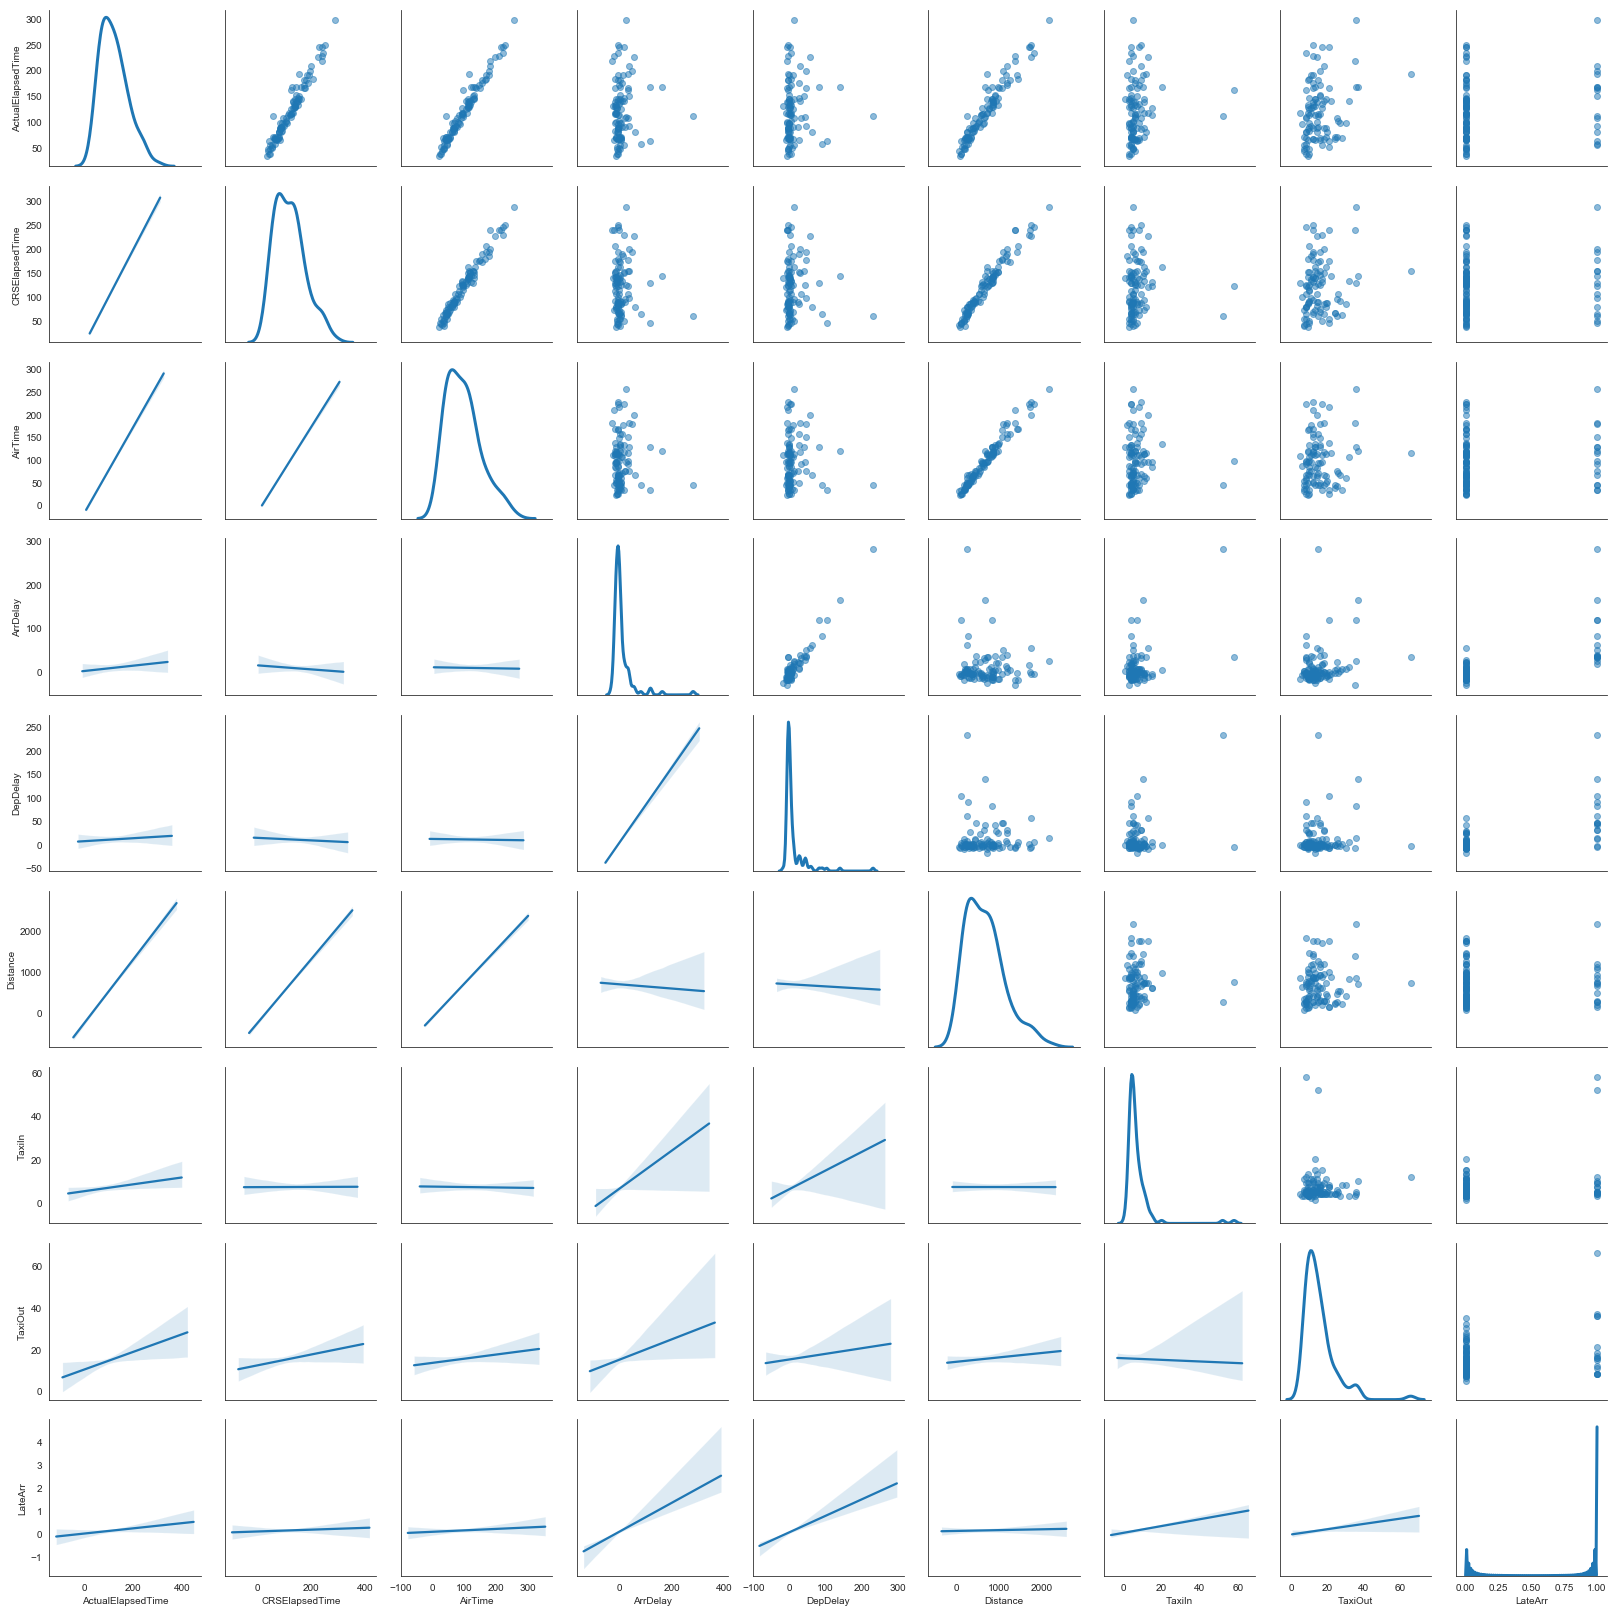

CPU times: user 25.6 s, sys: 3.73 s, total: 29.3 s
Wall time: 14.4 s


In [14]:
%%time

### Creating Scatterplot Matrix with Sample of DataFrame

## Store samples of DataFrame For Visualization

df_sample = df[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 
               'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 
               'TaxiIn', 'TaxiOut', 'LateArr']].sample(100)

## Declare Pairgrid
g = sns.PairGrid(df_sample.dropna(), diag_sharey=False)

## Scatterplot
g.map_upper(plt.scatter, alpha=.5)

## Fit line 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

## KDE plot
g.map_diag(sns.kdeplot, lw=3)
plt.show()

This scatterplot matrix was made to analyze the relationship between the continuous variables.
The topright half of the matrix gives scatterplots of each combination of variables while the bottom left gives the best fit lines corresponding to the relationship between each pair.
The diagonals consist of KDE plots which show the shape of the distribution of each variable.

The correlation between the scheduled elapsed time (CRSElapsedTime) and actual elapsed time (ActualElapsedTime) is very high but the fact that the scatterplot representing the relationship between the two variables doesn't appear as a straight line shows that there is significant variation between scheduled and actual elapsed time.
Airtime only seems to have high correlations with variables that directly affect how long the flights are (e.g. Distance) but not with the other variables (such as TaxiIn, LateArr etc.).
The Distance variable displays the same relationships as Airtime.


In [15]:
%%time

df.describe()

CPU times: user 761 ms, sys: 111 ms, total: 871 ms
Wall time: 927 ms


,Month,DayofMonth,DayOfWeek,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,LateArr
count,963353.000,963353.000,963353.000,963353.000,963353.000,963353.000,963353.000,963353.000,963353.000,963353.000,963353.000,963353.000,963353.000,963353.000
mean,6.406,15.900,3.925,127.258,129.007,103.949,8.190,9.939,728.208,6.864,16.446,0.000,0.000,0.134
std,3.394,8.755,1.984,70.180,69.503,67.414,38.604,35.316,563.041,4.939,11.306,0.000,0.000,0.341
min,1.000,1.000,1.000,15.000,2.000,1.000,-129.000,-71.000,11.000,0.000,0.000,0.000,0.000,0.000
25%,3.000,8.000,2.000,77.000,80.000,55.000,-10.000,-4.000,326.000,4.000,10.000,0.000,0.000,0.000
50%,6.000,16.000,4.000,110.000,111.000,86.000,-2.000,-1.000,581.000,6.000,14.000,0.000,0.000,0.000
75%,9.000,23.000,6.000,157.000,159.000,132.000,12.000,8.000,954.000,8.000,19.000,0.000,0.000,0.000
max,12.000,31.000,7.000,1114.000,660.000,1091.000,1542.000,1545.000,4962.000,200.000,383.000,0.000,0.000,1.000


These descriptive statistics supplement the scatterplot matrix by quantifying the distribution of the variables.
While many of the max values differ largely from 75 percent values, the datapoints may continuously cover the range between the 2 values, showing that the max values are not true outliers.

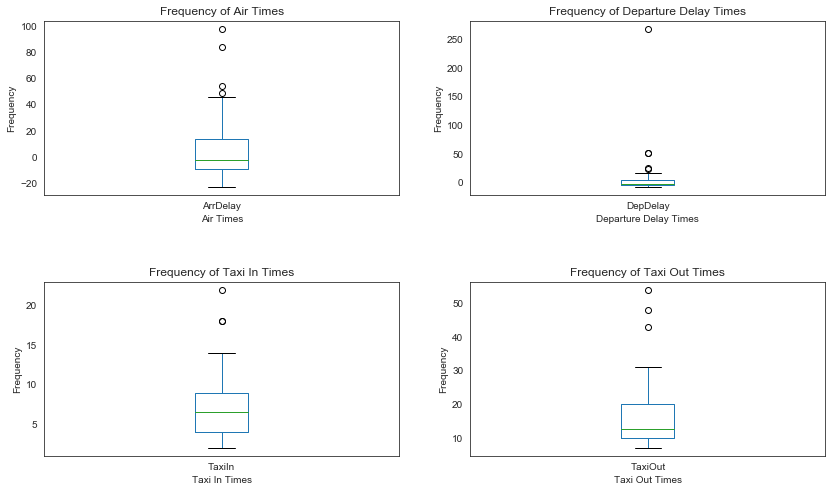

CPU times: user 1.21 s, sys: 171 ms, total: 1.38 s
Wall time: 735 ms


In [16]:
%%time

## Boxplot of Air Times

fig = plt.figure(figsize=(14, 8))
fig.subplots_adjust(hspace=.5)

plt.subplot(2, 2, 1)
ax = df.ArrDelay.sample(50).plot(kind='box',
                                    
                                    title="Frequency of Air Times")
ax.set_xlabel("Air Times")
ax.set_ylabel("Frequency")

## Boxplot of Departure Delay Times

plt.subplot(2, 2, 2)
ax = df.DepDelay.sample(50).plot(kind='box',
                                    
                                    title="Frequency of Departure Delay Times")
ax.set_xlabel("Departure Delay Times")
ax.set_ylabel("Frequency")

## Boxplot of Taxi In Times

plt.subplot(2, 2, 3)
ax = df.TaxiIn.sample(50).plot(kind='box',
                                    
                                    title="Frequency of Taxi In Times")
ax.set_xlabel("Taxi In Times")
ax.set_ylabel("Frequency")

## Boxplot of Taxi Out Times

plt.subplot(2, 2, 4)
ax = df.TaxiOut.sample(50).plot(kind='box',
                                    
                                    title="Frequency of Taxi Out Times")
ax.set_xlabel("Taxi Out Times")
ax.set_ylabel("Frequency")

plt.show()

While the boxplots show that there are significantly higher values than the 75 percentile, it is important to note that these boxplots reflect samples. As the sample sizes increase it can be seen that there are plenty of datapoints leading up to the extreme values shown.

## Preparing The Data For Modeling

To prepare the data for modeling, a new feature was engineered, the data was resampled to address the class imbalance in the outcome, and three forms of feature selection were implemented. This resulted in three sets of variables: One reflecting all of the features of the dataset, one reflecting features chosen by the selectKbest function and one reflecting PCA components.


In [17]:
%%time

## Engineering a New Feature to Capture the Differences Between Planned and Actual Elapsed Times

df['DiffElapsedTime'] = df['CRSElapsedTime'] - df['ActualElapsedTime']

CPU times: user 5.68 ms, sys: 1.8 ms, total: 7.48 ms
Wall time: 4.81 ms


The New feature was created since the model could gain from having a variable to note the differences/interaction between the scheduled and actual elapsed time variables as opposed to just the magnitude of each variable on its own.

In [18]:
%%time

## Class Balancing and Resampling

# Separate majority and minority classes
df_majority = df[df.LateArr==0]
df_minority = df[df.LateArr==1]

# Upsample minority class
df_minority_downsampled = resample(df_minority, 
                                 replace=False,     # sample with replacement
                                 n_samples=25000,    # to match majority class
                                 random_state=123) # reproducible results

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=25000,     # to match minority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df = pd.concat([df_majority_downsampled, df_minority_downsampled])

df.LateArr.value_counts()

CPU times: user 225 ms, sys: 75.9 ms, total: 301 ms
Wall time: 300 ms


Class balancing was done by downsampling both classes to reduce computational complexity and runtimes.

In [19]:
%%time

## Get Dummies so Categorical Variables Can be Used in Regression

df = pd.get_dummies(df)

## Display New Number of Features

len(df.columns)

CPU times: user 2.97 s, sys: 287 ms, total: 3.26 s
Wall time: 3.26 s


In [20]:
%%time

## Establish variables based on original components to be used for modeling

x = df.drop(['LateArr'], axis=1)
y = df.LateArr

CPU times: user 525 ms, sys: 474 ms, total: 998 ms
Wall time: 998 ms


In [21]:
%%time

## Establish variables based on select K best to be used for modeling

selector = SelectKBest(f_classif, k=200)
k_predictors = selector.fit_transform(x,y)

CPU times: user 12.2 s, sys: 8.65 s, total: 20.8 s
Wall time: 22.8 s


In [22]:
%%time

## PCA

# Normalize the data for PCA

X = StandardScaler().fit_transform(x)

# Perform PCA

sklearn_pca = PCA(n_components=200)
Y_sklearn = sklearn_pca.fit_transform(X)

# Turn PCA Result into Dataframe

pca_components = pd.DataFrame(data=Y_sklearn)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.00093721 0.00062412 0.00059003 0.00054842 0.00054644 0.00052425
 0.00051578 0.0005104  0.00049054 0.00046681 0.00045311 0.00043361
 0.00042076 0.00041315 0.00040744 0.0004027  0.00039191 0.00038125
 0.00037791 0.00035883 0.00035804 0.00034526 0.00033974 0.00033681
 0.00033229 0.0003277  0.00032257 0.00032039 0.0003173  0.00031508
 0.00031068 0.00030826 0.00030507 0.00030188 0.00029732 0.00029596
 0.00029277 0.00029024 0.00028981 0.00028723 0.00028607 0.00028367
 0.00027847 0.00027756 0.00027596 0.00027334 0.00027042 0.00027031
 0.0002692  0.00026673 0.00026634 0.00026447 0.00026356 0.00026262
 0.0002617  0.00025925 0.00025831 0.0002579  0.00025743 0.00025703
 0.00025549 0.00025481 0.00025388 0.00025357 0.00025271 0.00025241
 0.00025104 0.00025044 0.00024969 0.00024887 0.00024822 0.00024774
 0.00024665 0.00024629 0.00024595 0.00024547 0.00024493 0.00024402
 0.00024385 0.00024333 0.00024295 

In [23]:
%%time

## Train Test Split Original Variables And K Selected Variables for Modeling

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

kx_train, kx_test, ky_train, ky_test = train_test_split(k_predictors, y, test_size=0.2, random_state=21)

px_train, px_test, py_train, py_test = train_test_split(pca_components, y, test_size=0.2, random_state=21)

CPU times: user 997 ms, sys: 269 ms, total: 1.27 s
Wall time: 1.29 s


The x and y variables represent the variables to be used for modeling that reflect the full features of the data. The kx and ky variables represent the variables to be used for modeling that reflect features chosen by selectKbest. The px and py variables represent the variables to be used for modeling that reflect PCA components of the initial features. 

## Modeling the Data

The three sets of variables were modeled using the following techniques: 
Naive Bayes,
K Nearest Neighbors,
Decision Trees,
Random Forest,
Logistic Regression (and Lasso and Ridge),
Support Vector Classifier,
Gradient Boost,
Each model was evaluated using accuracy score, cross validation, cross validated AUC, a confusion matrix, and a classification report.

### Naive Bayes



In [24]:
%%time

## train and fit model

bnb = BernoulliNB().fit(x_train, y_train)


CPU times: user 13.6 s, sys: 1.97 s, total: 15.5 s
Wall time: 14.7 s


In [25]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(bnb.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(bnb, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(bnb, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, bnb.predict(x_test)))+'\n')

print(classification_report(y_test, bnb.predict(x_test)))


accuracy score:
0.8351

cross validation:
[0.82208896 0.83658171 0.851      0.84342171 0.83191596]

cross validation with AUC:
[0.87421727 0.8841865  0.89342929 0.89295481 0.88108871]

confusion matrix:
[[3750 1228]
 [ 421 4601]]

              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82      4978
         1.0       0.79      0.92      0.85      5022

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.83     10000

CPU times: user 43 s, sys: 8.54 s, total: 51.6 s
Wall time: 42.4 s


In [26]:
%%time

## train and fit model

k_bnb = BernoulliNB().fit(kx_train, ky_train)


CPU times: user 126 ms, sys: 53.2 ms, total: 179 ms
Wall time: 119 ms


In [27]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_bnb.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_bnb, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_bnb, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_bnb.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_bnb.predict(kx_test)))


accuracy score:
0.849

cross validation:
[0.857  0.8465 0.85   0.8325 0.844 ]

cross validation with AUC:
[0.9002974  0.8993524  0.8952779  0.88871789 0.9002769 ]

confusion matrix:
[[3826 1169]
 [ 341 4664]]

              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      4995
         1.0       0.80      0.93      0.86      5005

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

CPU times: user 991 ms, sys: 245 ms, total: 1.24 s
Wall time: 333 ms


In [28]:
%%time

## train and fit model

p_bnb = BernoulliNB().fit(px_train, py_train)


CPU times: user 209 ms, sys: 37.4 ms, total: 247 ms
Wall time: 217 ms


In [29]:
%%time
## Model Evaluation

print("accuracy score:\n" + str(p_bnb.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_bnb, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_bnb, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_bnb.predict(px_test)))+'\n')

print(classification_report(py_test, p_bnb.predict(px_test)))


accuracy score:
0.7512

cross validation:
[0.774  0.7515 0.744  0.735  0.7505]

cross validation with AUC:
[0.84849885 0.82750383 0.82579183 0.81910082 0.83048483]

confusion matrix:
[[3861 1134]
 [1354 3651]]

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.76      4995
         1.0       0.76      0.73      0.75      5005

   micro avg       0.75      0.75      0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

CPU times: user 2.15 s, sys: 470 ms, total: 2.62 s
Wall time: 704 ms


Naive Bayes had relatively low accuracy compared to most of the other models.
The model that used the selectKbest variables had the best performance of the naive bayes models.
The cross validation showed, that overfitting was not greatly present with this model. 
The model was better at predicting the negative class (not late).
The model likely had more trouble getting accurate predictions from the data because it assumes that the variables are independent from eachother (which isn't true when it comes to this data). 
However, the naive bayes model that used PCA components had worse performance. 
Despite the fact that PCA components are inherently independent, the lack of predictive value of the independent components compared to the 200 best features likely attributed to this drop in performance.


### K Nearest Neighbors 



In [30]:
%%time

## train and fit model

knn = neighbors.KNeighborsClassifier(n_neighbors=10).fit(x_train, y_train)


CPU times: user 37.5 s, sys: 2.75 s, total: 40.3 s
Wall time: 41.5 s


In [31]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(knn.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(knn, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(knn, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, knn.predict(x_test)))+'\n')

print(classification_report(y_test, knn.predict(x_test)))


accuracy score:
0.9461

cross validation:
[0.92603698 0.94352824 0.939      0.93996998 0.94147074]

cross validation with AUC:
[0.967343   0.97845312 0.97541111 0.97350498 0.97453953]

confusion matrix:
[[4791  187]
 [ 352 4670]]

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      4978
         1.0       0.96      0.93      0.95      5022

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

CPU times: user 5min 23s, sys: 9.38 s, total: 5min 32s
Wall time: 5min 37s


In [32]:
%%time

## train and fit model

k_knn = neighbors.KNeighborsClassifier(n_neighbors=10).fit(kx_train, ky_train)


CPU times: user 660 ms, sys: 89.2 ms, total: 749 ms
Wall time: 804 ms


In [33]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_knn.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_knn, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_knn, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_knn.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_knn.predict(kx_test)))


accuracy score:
0.9451

cross validation:
[0.941  0.9395 0.9375 0.9365 0.936 ]

cross validation with AUC:
[0.97285947 0.97167847 0.97256847 0.96865197 0.97905148]

confusion matrix:
[[4786  209]
 [ 340 4665]]

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      4995
         1.0       0.96      0.93      0.94      5005

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

CPU times: user 13.2 s, sys: 126 ms, total: 13.3 s
Wall time: 13.4 s


In [34]:
%%time

## train and fit model

p_knn = neighbors.KNeighborsClassifier(n_neighbors=10).fit(px_train, py_train)


CPU times: user 782 ms, sys: 187 ms, total: 968 ms
Wall time: 1.09 s


In [35]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_knn.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_knn, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_knn, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_knn.predict(px_test)))+'\n')

print(classification_report(py_test, p_knn.predict(px_test)))


accuracy score:
0.5941

cross validation:
[0.6165 0.611  0.6125 0.6205 0.6065]

cross validation with AUC:
[0.65741416 0.64748815 0.65490165 0.65802816 0.65480465]

confusion matrix:
[[3570 1425]
 [2634 2371]]

              precision    recall  f1-score   support

         0.0       0.58      0.71      0.64      4995
         1.0       0.62      0.47      0.54      5005

   micro avg       0.59      0.59      0.59     10000
   macro avg       0.60      0.59      0.59     10000
weighted avg       0.60      0.59      0.59     10000

CPU times: user 8min 52s, sys: 3.07 s, total: 8min 56s
Wall time: 9min


KNN had relatively high performance in this study.
For all versions of this model, the number of false negatives was greater.
The model that used the selectKbest variables had the best performance of the knn models. 
The cross validation showed that overfitting was not greatly present with this model. 
The model was better at predicting the positive class. 
The model benefits from being able to rely on data where the outcome class can be linked to clustering of datapoints (e.g. at a certain range of delay values the likelihood of LateArr being 1 could significantly increase)
The knn model that used PCA components had significantly low performance. This was likely due to the lack of individual predictive value of the individual PCA components.


### Decision Tree



In [36]:
%%time

## train and fit model

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=25,
    ).fit(x_train, y_train)



CPU times: user 1.61 s, sys: 2.43 s, total: 4.03 s
Wall time: 4.84 s


In [37]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(decision_tree.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(decision_tree, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(decision_tree, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, decision_tree.predict(x_test)))+'\n')

print(classification_report(y_test, decision_tree.predict(x_test)))


accuracy score:
0.506

cross validation:
[0.50374813 0.56121939 0.5045     0.50275138 0.52676338]

cross validation with AUC:
[0.5043917  0.5038752  0.5065186  0.50050652 0.4980425 ]

confusion matrix:
[[4711  267]
 [4673  349]]

              precision    recall  f1-score   support

         0.0       0.50      0.95      0.66      4978
         1.0       0.57      0.07      0.12      5022

   micro avg       0.51      0.51      0.51     10000
   macro avg       0.53      0.51      0.39     10000
weighted avg       0.53      0.51      0.39     10000

CPU times: user 5.63 s, sys: 4.31 s, total: 9.94 s
Wall time: 10.4 s


In [38]:
%%time

## train and fit model

k_decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=25,
    ).fit(kx_train, ky_train)


CPU times: user 140 ms, sys: 69.1 ms, total: 209 ms
Wall time: 209 ms


In [39]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_decision_tree.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_decision_tree, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_decision_tree, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_decision_tree.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_decision_tree.predict(kx_test)))


accuracy score:
0.7412

cross validation:
[0.9035 0.9135 0.754  0.7625 0.951 ]

cross validation with AUC:
[0.95167245 0.90576591 0.85443735 0.9003174  0.88612139]

confusion matrix:
[[4051  944]
 [1644 3361]]

              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76      4995
         1.0       0.78      0.67      0.72      5005

   micro avg       0.74      0.74      0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000

CPU times: user 258 ms, sys: 43.6 ms, total: 301 ms
Wall time: 305 ms


In [40]:
%%time

## train and fit model

p_decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=25,
    ).fit(px_train, py_train)


CPU times: user 718 ms, sys: 74.7 ms, total: 793 ms
Wall time: 798 ms


In [41]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_decision_tree.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_decision_tree, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_decision_tree, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_decision_tree.predict(px_test)))+'\n')

print(classification_report(py_test, p_decision_tree.predict(px_test)))



accuracy score:
0.6864

cross validation:
[0.6205 0.617  0.6245 0.661  0.648 ]

cross validation with AUC:
[0.62540763 0.62782463 0.62216862 0.60964811 0.61280911]

confusion matrix:
[[3433 1562]
 [1574 3431]]

              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      4995
         1.0       0.69      0.69      0.69      5005

   micro avg       0.69      0.69      0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

CPU times: user 1.23 s, sys: 32.8 ms, total: 1.26 s
Wall time: 1.27 s


The decision tree had the worst performance out of all of the model types in this study.
The model that used the selectKbest variables had the best performance of the decision tree models. 
Even with this model there were strong signs of overfitting. 
The model was better at predicting the positive class. 
The model's reliance on binary divisions likely hurt its ability to capture nuance within the data.
This was likely to be especially true for the model that used PCA components since the lack of variation in the best PCA components compared to the features chosen by selectKbest likely resulted in more uneven splitting of the datapoints at each node. 


### Random Forest



In [42]:
%%time

## Fit and Train Model

rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features=15,
    max_depth=100,
    ).fit(x_train, y_train)



CPU times: user 4.5 s, sys: 1.99 s, total: 6.49 s
Wall time: 7.06 s


In [43]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(rfc.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(rfc, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(rfc, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, rfc.predict(x_test)))+'\n')

print(classification_report(y_test, rfc.predict(x_test)))


accuracy score:
0.9227

cross validation:
[0.90554723 0.91904048 0.942      0.91345673 0.90245123]

cross validation with AUC:
[0.95003247 0.97185958 0.96811499 0.96109482 0.97142886]

confusion matrix:
[[4704  274]
 [ 499 4523]]

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      4978
         1.0       0.94      0.90      0.92      5022

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

CPU times: user 9.56 s, sys: 3.85 s, total: 13.4 s
Wall time: 13.5 s


In [44]:
%%time

## Fit and Train Model

k_rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features=15,
    max_depth=100,
    ).fit(kx_train, ky_train)



CPU times: user 968 ms, sys: 19.5 ms, total: 987 ms
Wall time: 990 ms


In [45]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_rfc.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_rfc, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_rfc, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_rfc.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_rfc.predict(kx_test)))


accuracy score:
0.9653

cross validation:
[0.9655 0.9605 0.9625 0.9545 0.9605]

cross validation with AUC:
[0.98464348 0.97937948 0.98145348 0.97741498 0.98571649]

confusion matrix:
[[4880  115]
 [ 232 4773]]

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      4995
         1.0       0.98      0.95      0.96      5005

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

CPU times: user 1.37 s, sys: 69.5 ms, total: 1.44 s
Wall time: 1.46 s


In [46]:
%%time

## Fit and Train Model

p_rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features=15,
    max_depth=100,
    ).fit(px_train, py_train)


CPU times: user 8.7 s, sys: 49.4 ms, total: 8.75 s
Wall time: 8.79 s


In [47]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_rfc.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_rfc, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_rfc, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_rfc.predict(px_test)))+'\n')

print(classification_report(py_test, p_rfc.predict(px_test)))


accuracy score:
0.8233

cross validation:
[0.7755 0.7605 0.7805 0.782  0.787 ]

cross validation with AUC:
[0.85594836 0.86115436 0.84520785 0.85768936 0.85834636]

confusion matrix:
[[4420  575]
 [1192 3813]]

              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83      4995
         1.0       0.87      0.76      0.81      5005

   micro avg       0.82      0.82      0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000

CPU times: user 13.7 s, sys: 152 ms, total: 13.8 s
Wall time: 13.9 s



Random forest had relatively high accuracy compared to most of the other models.
The model that used the selectKbest variables had the best performance of the random forest models.
The cross validation showed, that overfitting was not greatly present with this model. 
The model was better at predicting the positive outcome class.
The model's success likely comes from it not having to rely on each set of data being evaluated only once. 
By being able to base its evaluations on multiple sub decision trees classifications are only finalized after multiple iterations.
Even the the model that used PCA components, the worst performing random forest model, had relatively high performance.




### Logistic Regression 



In [48]:
%%time

## train and fit model

lr = LogisticRegression(penalty='l1' ).fit(x_train, y_train)


CPU times: user 8.84 s, sys: 1.71 s, total: 10.6 s
Wall time: 10.6 s


In [49]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(lr.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(lr, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(lr, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, lr.predict(x_test)))+'\n')

print(classification_report(y_test, lr.predict(x_test)))


accuracy score:
0.9453

cross validation:
[0.93653173 0.95102449 0.9515     0.94297149 0.94697349]

cross validation with AUC:
[0.96768367 0.97710644 0.97355058 0.97335983 0.97418467]

confusion matrix:
[[4733  245]
 [ 302 4720]]

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      4978
         1.0       0.95      0.94      0.95      5022

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

CPU times: user 17.7 s, sys: 5.53 s, total: 23.2 s
Wall time: 18.8 s


In [50]:
%%time

## train and fit model

k_lr = LogisticRegression(penalty='l1' ).fit(kx_train, ky_train)


CPU times: user 1.75 s, sys: 23.5 ms, total: 1.78 s
Wall time: 1.78 s


In [51]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_lr.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_lr, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_lr, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_lr.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_lr.predict(kx_test)))


accuracy score:
0.9487

cross validation:
[0.955  0.9435 0.9435 0.943  0.954 ]

cross validation with AUC:
[0.97836598 0.97507198 0.97155597 0.97056797 0.98010998]

confusion matrix:
[[4741  254]
 [ 259 4746]]

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      4995
         1.0       0.95      0.95      0.95      5005

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

CPU times: user 5.2 s, sys: 813 ms, total: 6.02 s
Wall time: 2.32 s


In [52]:
%%time

## train and fit model

p_lr = LogisticRegression(penalty='l1' ).fit(px_train, py_train)


CPU times: user 1.29 s, sys: 186 ms, total: 1.48 s
Wall time: 1.5 s


In [53]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_lr.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_lr, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_lr, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_lr.predict(px_test)))+'\n')

print(classification_report(py_test, p_lr.predict(px_test)))


accuracy score:
0.8896

cross validation:
[0.8985 0.8765 0.8805 0.878  0.8865]

cross validation with AUC:
[0.95040595 0.93895094 0.94200094 0.94096394 0.94648195]

confusion matrix:
[[4522  473]
 [ 631 4374]]

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89      4995
         1.0       0.90      0.87      0.89      5005

   micro avg       0.89      0.89      0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

CPU times: user 5.46 s, sys: 913 ms, total: 6.38 s
Wall time: 2.68 s


The logistic regression models had relatively high accuracy compared to most of the other models.
Unlike the majority of the models, the version that used all of the dataset's features had the best performance of the logistic regression models.
The cross validation showed, that overfitting was not greatly present with this model. 
The model had similar rates of type 1 and type 2 error.
The model likely benefitted from being ably to drop parameters that were deemed to be excessively low.
This likely effectively removed features that would've hurt the predictive ability of the model. 
Since this regression technique worked this way, it effectively acted as the version of the model with K best features with the primary difference of being able to pick any number of features that would aid the model.
The model using PCA components was still the worst performing of the three but still had high accuracy.



### Support Vector 



In [54]:
%%time

## train and fit model

svc = SVC().fit(x_train, y_train)


CPU times: user 42min 53s, sys: 27.4 s, total: 43min 21s
Wall time: 44min 25s


In [55]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(svc.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(svc, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(svc, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, svc.predict(x_test)))+'\n')

print(classification_report(y_test, svc.predict(x_test)))


accuracy score:
0.9492

cross validation:
[0.93453273 0.94652674 0.9465     0.94197099 0.95197599]

cross validation with AUC:
[0.97942317 0.98552219 0.98176671 0.97869727 0.98016777]

confusion matrix:
[[4764  214]
 [ 294 4728]]

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      4978
         1.0       0.96      0.94      0.95      5022

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

CPU times: user 41min 22s, sys: 23.2 s, total: 41min 46s
Wall time: 42min 11s


In [56]:
%%time

## train and fit model

k_svc = SVC().fit(kx_train, ky_train)


CPU times: user 16min 52s, sys: 4.56 s, total: 16min 56s
Wall time: 17min 2s


In [57]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_svc.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_svc, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_svc, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_svc.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_svc.predict(kx_test)))


accuracy score:
0.9013

cross validation:
[0.853  0.857  0.8545 0.8395 0.858 ]

cross validation with AUC:
[0.96585297 0.96007096 0.96607847 0.96157846 0.96558647]

confusion matrix:
[[4181  814]
 [ 173 4832]]

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89      4995
         1.0       0.86      0.97      0.91      5005

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

CPU times: user 7min 3s, sys: 3.61 s, total: 7min 6s
Wall time: 7min 9s


In [58]:
%%time

## train and fit model

p_svc = SVC().fit(px_train, py_train)


CPU times: user 7min 5s, sys: 3.56 s, total: 7min 9s
Wall time: 7min 12s


In [59]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_svc.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_svc, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_svc, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_svc.predict(px_test)))+'\n')

print(classification_report(py_test, p_svc.predict(px_test)))


accuracy score:
0.8728

cross validation:
[0.855  0.848  0.844  0.8505 0.8585]

cross validation with AUC:
[0.93277393 0.92436292 0.92456792 0.92293192 0.93676394]

confusion matrix:
[[4486  509]
 [ 763 4242]]

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.88      4995
         1.0       0.89      0.85      0.87      5005

   micro avg       0.87      0.87      0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

CPU times: user 4min 1s, sys: 1.83 s, total: 4min 3s
Wall time: 4min 4s



The support vector classifier had middling accuracy compared to most of the other models.
Unlike the majority of the models, the version that used all of the dataset's features had the best performance of the logistic regression models.
The cross validation showed, that overfitting was not greatly present with this model. 
The model was marginally better at predicting the positive class.
The model likely gained from using all of the features of the data because the differences in the data serve as the basis in which boundaries are formed and such nuance could be lost when a large amount of the variance of the data is left out through feature selection. 




### Gradient Boost 



In [65]:
%%time

## train and fit model

cl = ensemble.GradientBoostingClassifier()

parameters = { 
              'n_estimators': list(np.arange(200, 301, 50)),
              'max_depth': list(range(1,3)),
              'loss': ['deviance', 'exponential']
             }

acc_scorer = make_scorer(accuracy_score)

clf = GridSearchCV(cl, parameters, scoring=acc_scorer).fit(x_train,  y_train)

## Show Best Parameters
print(clf.best_params_)


{'loss': 'deviance', 'max_depth': 1, 'n_estimators': 250}
CPU times: user 2h 13min 14s, sys: 2min 23s, total: 2h 15min 38s
Wall time: 2h 16min 11s


In [66]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(clf.score(x_test, y_test))+'\n')

print("cross validation:\n" + str(cross_val_score(clf, x_test, y_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(clf, x_test, y_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(y_test, clf.predict(x_test)))+'\n')

print(classification_report(y_test, clf.predict(x_test)))

accuracy score:
0.9676

cross validation:
[0.96051974 0.97051474 0.97       0.96448224 0.97048524]

cross validation with AUC:
[0.98166697 0.98771804 0.98430375 0.98272538 0.98394562]

confusion matrix:
[[4858  120]
 [ 204 4818]]

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      4978
         1.0       0.98      0.96      0.97      5022

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

CPU times: user 3h 19min 28s, sys: 3min 55s, total: 3h 23min 23s
Wall time: 4h 5min 38s


In [68]:
%%time

## train and fit model

k_clf = GridSearchCV(cl, parameters, scoring=acc_scorer).fit(kx_train,  ky_train)


CPU times: user 11min 48s, sys: 5.87 s, total: 11min 53s
Wall time: 11min 57s


In [69]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(k_clf.score(kx_test, ky_test))+'\n')

print("cross validation:\n" + str(cross_val_score(k_clf, kx_test, ky_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(k_clf, kx_test, ky_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(ky_test, k_clf.predict(kx_test)))+'\n')

print(classification_report(ky_test, k_clf.predict(kx_test)))

accuracy score:
0.968

cross validation:
[0.9705 0.9705 0.965  0.9625 0.9705]

cross validation with AUC:
[0.98723649 0.98763699 0.98559399 0.98475298 0.98979849]

confusion matrix:
[[4854  141]
 [ 179 4826]]

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      4995
         1.0       0.97      0.96      0.97      5005

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

CPU times: user 15min 44s, sys: 7.74 s, total: 15min 52s
Wall time: 15min 56s


In [70]:
%%time

## train and fit model

p_clf = GridSearchCV(cl, parameters, scoring=acc_scorer).fit(px_train,  py_train)


CPU times: user 45min 27s, sys: 12 s, total: 45min 39s
Wall time: 45min 48s


In [71]:
%%time

## Model Evaluation

print("accuracy score:\n" + str(p_clf.score(px_test, py_test))+'\n')

print("cross validation:\n" + str(cross_val_score(p_clf, px_test, py_test, cv=5))+'\n')

print("cross validation with AUC:\n" + str(cross_val_score(p_clf, px_test, py_test, cv=5, scoring='roc_auc'))+'\n')

print("confusion matrix:\n" + str(confusion_matrix(py_test, p_clf.predict(px_test)))+'\n')

print(classification_report(py_test, p_clf.predict(px_test)))

accuracy score:
0.8739

cross validation:
[0.882  0.869  0.867  0.86   0.8595]

cross validation with AUC:
[0.94280794 0.93301093 0.93011993 0.92932893 0.93851694]

confusion matrix:
[[4459  536]
 [ 725 4280]]

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88      4995
         1.0       0.89      0.86      0.87      5005

   micro avg       0.87      0.87      0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

CPU times: user 1h 21min 28s, sys: 21.7 s, total: 1h 21min 50s
Wall time: 1h 42min 19s


The gradient boost had the relatively highest accuracy compared to most of the other models.
The model that used the selectKbest variables had the best performance of the gradient boost models. 
However, it was only marginally better than the gradient boost model that used all of the features of the dataset.
The cross validation showed, that overfitting was not present with this model. 
The model was equally good at predicting both classes.
The strength of this model when it comes to making predictions using this data comes from its ability to reduce error over multiple iterations.


## Analysis and Conclusion

The gradient boost model using features selected by the selectKbest function was by far the best model when it comes to predicting airline delay.
It is also important to note that the logistic regression model could also prove valuable when it comes to making predictions using this data due to its low computational complexity and its ability to garner high accuracy scores using all of the features of the dataset.

Understanding how to better utilize supervised modeling techniques to predict flight delay, will give insight how to curtail the incidence of late airline arrivals. 
The resulting increase in efficiency, could save airlines money and improve the process of flying for all of its customers.

This study established the best suprvised modeling technique and feature classification pairing for predicting late airline arrivals. The next step in using this data to improve airline efficiency would be to collect more types of data and go more in depth into which features have a greater impact on the likelihood of late arrivals. This includes collecting data from different sources and engineering more features. By identifying potential causes of flight delay a new avenue for addressing the issue can be opened, resulting in new opportunities to increase efficiency and improve the growth of airlines.
